In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Installing Required Libraries

In [2]:
# !pip install -U transformers
# !pip install -U accelerate
# !pip install -U datasets
# !pip install -U bertviz
# !pip install -U umap-learn
# !pip install -U transformers

# Importing Required Libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from transformers import AutoTokenizer
from datasets import Dataset, DatasetDict
from transformers import AutoModel
import torch
from transformers import AutoModelForSequenceClassification, AutoConfig
from sklearn.metrics import accuracy_score, f1_score
from transformers import Trainer
from transformers import TrainingArguments


In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import __version__ as sklearn_version
from transformers import __version__ as transformers_version
from datasets import __version__ as datasets_version
import torch

# Printing versions of each library
print("Pandas version:", pd.__version__)
print("NumPy version:", np.__version__)
print("Matplotlib version:", plt.matplotlib.__version__)
print("Seaborn version:", sns.__version__)
print("Scikit-learn version:", sklearn_version)
print("Transformers version:", transformers_version)
print("Datasets version:", datasets_version)
print("Torch version:", torch.__version__)


Pandas version: 2.2.2
NumPy version: 1.26.4
Matplotlib version: 3.10.0
Seaborn version: 0.13.2
Scikit-learn version: 1.6.0
Transformers version: 4.48.0
Datasets version: 3.2.0
Torch version: 2.5.1+cu121
Evaluate version: 0.4.3


# Loading Dataset

In [4]:
df = pd.read_csv('/content/drive/MyDrive/MultiClassSentimentAnalysis/df.csv')
print(df.shape)
df.head()

(16000, 3)


,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


In [5]:
df.isnull().sum()

,0
text,0
label,0
label_name,0


In [6]:
df.duplicated().sum()

1

In [7]:
df.drop_duplicates(inplace=True)

In [8]:
df['label'].value_counts()

,count
label,
1,5361
0,4666
3,2159
4,1937
2,1304
5,572


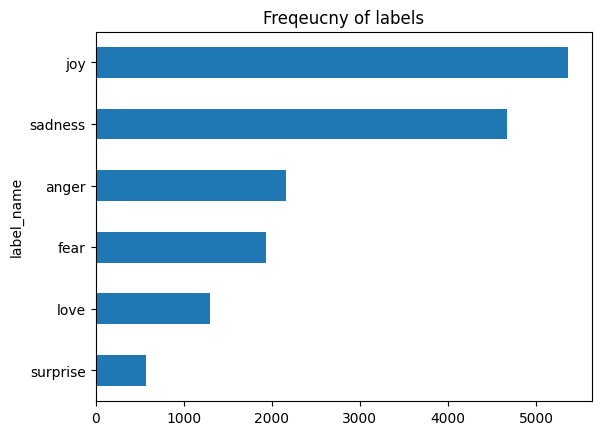

In [9]:
label_counts=df['label_name'].value_counts(ascending=True)
label_counts.plot.barh()
plt.title('Freqeucny of labels')
plt.show()

<Axes: title={'center': 'words_per_tweet'}, xlabel='label_name'>

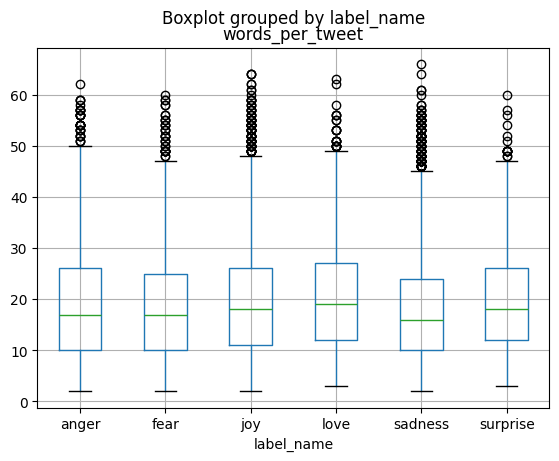

In [10]:
df['words_per_tweet']=df['text'].str.split().apply(len)
df.boxplot(['words_per_tweet'], by='label_name')


# Loading Tokenizer

In [11]:
model_ckpt='bert-base-uncased'
tokenizer=AutoTokenizer.from_pretrained(model_ckpt)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [12]:
test_sentence = 'I love Machine Leanring.'
test_tokens = tokenizer(test_sentence)
print(test_tokens)

{'input_ids': [101, 1045, 2293, 3698, 8155, 4892, 1012, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1]}


In [13]:
tokenizer.model_max_length, tokenizer.vocab_size

(512, 30522)

# Train-Test-Split

In [14]:
train_df, temp = train_test_split(df, test_size=0.3, random_state=42, stratify=df['label_name'])
test_df, val_df = train_test_split(temp, test_size=1/3, random_state=42, stratify=temp['label_name'])
train_df.shape, test_df.shape, val_df.shape

((11199, 4), (3200, 4), (1600, 4))

In [15]:
dataset = DatasetDict({
    'train': Dataset.from_pandas(train_df, preserve_index=False),
    'test': Dataset.from_pandas(test_df, preserve_index=False),
    'val': Dataset.from_pandas(val_df, preserve_index=False)
})

dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'label_name', 'words_per_tweet'],
        num_rows: 11199
    })
    test: Dataset({
        features: ['text', 'label', 'label_name', 'words_per_tweet'],
        num_rows: 3200
    })
    val: Dataset({
        features: ['text', 'label', 'label_name', 'words_per_tweet'],
        num_rows: 1600
    })
})

In [16]:
dataset['train'][0]

{'text': 'i feel disappointed for so dont say sorry dont say baby',
 'label': 0,
 'label_name': 'sadness',
 'words_per_tweet': 11}

# Implementing Tokenization

In [17]:
def tokenize(batch):
  return tokenizer(batch['text'], padding=True, truncation=True)

tokenize(dataset['train'][0])

{'input_ids': [101, 1045, 2514, 9364, 2005, 2061, 2123, 2102, 2360, 3374, 2123, 2102, 2360, 3336, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [18]:
emotion_embeded=dataset.map(tokenize, batched=True, batch_size=None)

emotion_embeded

Map:   0%|          | 0/11199 [00:00<?, ? examples/s]

Map:   0%|          | 0/3200 [00:00<?, ? examples/s]

Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'label_name', 'words_per_tweet', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 11199
    })
    test: Dataset({
        features: ['text', 'label', 'label_name', 'words_per_tweet', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3200
    })
    val: Dataset({
        features: ['text', 'label', 'label_name', 'words_per_tweet', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1600
    })
})

In [19]:
label_to_id = {x['label_name']:x['label'] for x in dataset['train']}
id_to_label = {v:k for k,v in label_to_id.items()}

label_to_id, id_to_label

({'sadness': 0, 'joy': 1, 'fear': 4, 'surprise': 5, 'anger': 3, 'love': 2},
 {0: 'sadness', 1: 'joy', 4: 'fear', 5: 'surprise', 3: 'anger', 2: 'love'})

# Loading a Pre-trained Model

In [20]:
model = AutoModel.from_pretrained(model_ckpt)


In [21]:
model

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

# Fine-tuning

In [22]:
num_labels=len(label_to_id)
device=torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
config=AutoConfig.from_pretrained(model_ckpt, label2id=label_to_id, id2label=id_to_label)
model=AutoModelForSequenceClassification.from_pretrained(model_ckpt, config=config).to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [23]:
model.config

BertConfig {
  "_attn_implementation_autoset": true,
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "sadness",
    "1": "joy",
    "2": "love",
    "3": "anger",
    "4": "fear",
    "5": "surprise"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "anger": 3,
    "fear": 4,
    "joy": 1,
    "love": 2,
    "sadness": 0,
    "surprise": 5
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.48.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

In [34]:
# Parameters
batch_size = 64

training_dir = '/content/drive/MyDrive/MultiClassSentimentAnalysis/bert_base_train_dir'

# Define TrainingArguments
training_args = TrainingArguments(
    output_dir=training_dir,           # Directory to save checkpoints and logs
    overwrite_output_dir=True,         # Overwrite output_dir if it already exists
    evaluation_strategy='epoch',       # Evaluate at the end of each epoch
    save_strategy='epoch',             # Save checkpoints at the end of each epoch
    save_total_limit=2,                # Keep only the last 2 checkpoints
    learning_rate=2e-5,                # Learning rate
    per_device_train_batch_size=batch_size,  # Batch size for training
    per_device_eval_batch_size=batch_size,   # Batch size for evaluation
    num_train_epochs=2,                # Number of training epochs
    weight_decay=0.01,                 # Weight decay for regularization
    disable_tqdm=False,                # Show progress bars
    logging_dir='./logs',              # Directory for logs (for TensorBoard/W&B)
    logging_steps=500,                 # Log metrics every 500 steps
    run_name="bert-finetuning-run",    # Experiment name for tracking
    gradient_accumulation_steps=1,     # Adjust if batch size needs to be divided
    load_best_model_at_end=True,       # Automatically load the best checkpoint
    metric_for_best_model="accuracy",  # Metric used to identify the best model
    greater_is_better=True             # Whether a higher value of the metric is better
)


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [25]:

def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  f1 = f1_score(labels, preds, average='weighted')
  acc = accuracy_score(labels, preds)
  return {'accuracy': acc, 'f1': f1}


In [35]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=emotion_embeded['train'],
    eval_dataset=emotion_embeded['val'],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer
)

<ipython-input-35-7491b06f3f5e>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


# Model Training

In [36]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.224386,0.920625,0.921815
2,No log,0.179420,0.923125,0.924138


TrainOutput(global_step=350, training_loss=0.1718202427455357, metrics={'train_runtime': 346.5717, 'train_samples_per_second': 64.627, 'train_steps_per_second': 1.01, 'total_flos': 1001413001657736.0, 'train_loss': 0.1718202427455357, 'epoch': 2.0})

# Model Evaluation

In [37]:
pred_output=trainer.predict(emotion_embeded['test'])
pred_output.metrics

{'test_loss': 0.19413939118385315,
 'test_accuracy': 0.928125,
 'test_f1': 0.9286003857801606,
 'test_runtime': 12.3363,
 'test_samples_per_second': 259.397,
 'test_steps_per_second': 4.053}

In [38]:
y_pred = np.argmax(pred_output.predictions, axis=1)
y_true = emotion_embeded['test']['label']

print(classification_report(y_true, y_pred, target_names=label_to_id.keys()))

              precision    recall  f1-score   support

     sadness       0.96      0.96      0.96       933
         joy       0.97      0.93      0.95      1072
        fear       0.82      0.91      0.86       261
    surprise       0.93      0.92      0.92       432
       anger       0.87      0.93      0.90       387
        love       0.80      0.77      0.78       115

    accuracy                           0.93      3200
   macro avg       0.89      0.90      0.89      3200
weighted avg       0.93      0.93      0.93      3200



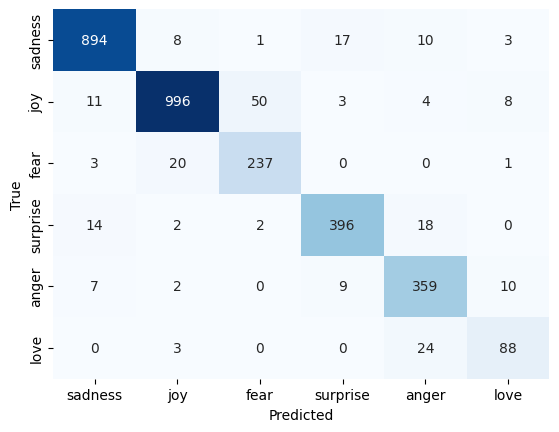

In [39]:
cm=confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=label_to_id.keys(), yticklabels=label_to_id.keys(), cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Testing and Saving our Model

In [40]:
text = 'I do not think if i have enjoyed this project a lot. I was not very excited in the begining however.'

def get_prediction(text):
  text_encoded = tokenizer(text, return_tensors='pt').to(device)
  with torch.no_grad():
    output = model(**text_encoded)
  prediction = torch.argmax(output.logits, dim=1).item()
  return id_to_label[prediction]

In [41]:
trainer.save_model('bert_base_model')

In [42]:
trainer.save_model('/content/drive/MyDrive/MultiClassSentimentAnalysis/model')